## Lab 06: The Multi-Layer Perceptron (MLP) and Backpropagation.


In this lab we will go from single-neurons to feedforward networks by implementing a simple Multi-Layer Perceptron (MLP) and the famous backpropagation algorithm to train an MLP from labeled data.

The MLP extends Perceptrons to multiple layers with one caveat: We are going to switch to continous activation functions instead of the heavyside 0/1 activation first analyzed by Rosenblatt. In our case, we'll use the sigmoid activation function: 

$$\sigma(x) = \frac{1}{1+e^{x}}$$

The architecture we will implement is simple, from inp layer to hidden layer to output layer:

```3 inputs -> 2 hidden units (sigmoid-activation) -> 1 output unit (sigmoid-activation)```

As we go from neurons to networks, all weight vectors of neurons in one layer are collected in a matrix. For example, the equation for the hidden layer is:

$$ \mathbf{h} = \sigma( W^{(1)} \mathbf{x} + \mathbf{b^{(1)}} ) $$

where $ W^{(1)} \in \mathbb{R}^{m \times n}$, $ \mathbf{x} \in \mathbb{R}^n$ and $\mathbf{h},\mathbf{b} \in \mathbb{R}^m $. The original weight vectors for each of the hidden layer perceptrons can be found in the weight matrix as row vectors:

$$ W^{(1)} = \begin{bmatrix}
- & \mathbf{w_1} & - \\
- & \mathbf{w_2} & - \end{bmatrix} $$

and $\mathbf{w_1}, \mathbf{w_2} \in \mathbb{R}^n$. Correspondingly, the output layer is:

$$ \mathbf{h} = \sigma( W^{(2)} \mathbf{h} + \mathbf{b}^{(2)} ) $$

Notice, that we are now explicityly tracking biases.

To be able to train the network, we will need to be able to quantify its performance using a loss function and minimizing it. We will do so by using the (mean-)squared error (MSE):

$$L(\hat{y},y) = \frac{1}{2} (\hat{y} - y)^2$$
$$L(\hat{y},y) = \frac{1}{2N} \sum (\hat{y_i} - y_i)^2$$

where $\hat{y}$ is the prediction, i.e. the output, of our network, and y is the target variable.



## Learning objectives
1. Practise the mechanics of the forward pass through linear layers + activation
1. Translate analytical gradients into numpy code
1. See how gradient descent gradually reduces the loss

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

np.random.seed(42)


# the sigmoid functions and its derivative
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [2]:
# setup dummy data
n_samples = 200
inputs = np.random.uniform(-1, 1, size=(n_samples, 3))

true_w = np.array([1.5, -2.0, 0.5])
true_b = -0.1
targets = sigmoid(inputs @ true_w + true_b)

# setup initial network parameters (all weights and biases)
n_hidden_units = 2
W1 = 0.1 * np.random.randn(n_hidden_units, 3)
b1 = np.zeros(n_hidden_units)

n_output_hidden = 1
W2 = 0.1 * np.random.randn(n_output_hidden, 2)
b2 = np.zeros(n_output_hidden)
print(W1.shape)
print(W2.shape)

class MLP:
    def __init__(self, dimensions):
        self.activation_fn = sigmoid
        
        self.layers = []
        
        for in_dimension, i in enumerate(dimensions):
            out_dimension = dimensions[i+1]
            weight = 0.1 * np.random.randn(in_dimension, 2)
            bias = np.zeros(in_dimension)
            self.layers.append((weight, bias))
            
            

    def forward(self, x):
        z1 = W1 @ x + b1
        a1 = sigmoid(z1)
        z2 = W2 @ a1 + b2
        a2 = sigmoid(z2)
        return a2

(2, 3)
(1, 2)


### Task 1

Your first task is to write a function that implements the forward pass of the network.
Use a scatterplot to visualise the random predictions vs the true outputs and calculate the MSE across the dataset.

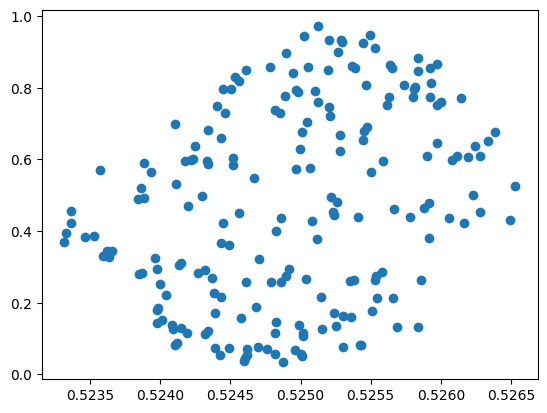

In [3]:
# returns the prediction of your network.
def forward_pass(inp, W1, b1, W2, b2):
    # print("inp.shape", inp.shape, "W1.shape", W1.shape, "W2.shape", W2.shape)
    # print("inp", inp, "\nW1", W1, "\nW2", W2, "\n\n")
    z1 = W1 @ inp + b1
    a1 = sigmoid(z1)
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    return a2


# returns the squared loss for one data point
def mse_loss(prediction, target):
    return np.mean((prediction - target) ** 2) / 2


# write a loop over the data that collects all predictions in a list, sums the individual losses.
# Then, take the mean of the loss and plot predictions against targets.

predictions = []
train_loss = 0.0
for x, target in zip(inputs, targets):
    pred = forward_pass(x, W1, b1, W2, b2)
    loss = mse_loss(pred, target)
    train_loss += loss
    predictions.append(pred)
    # print(f"loss {loss}, target{ target} pred{pred}")

mean_loss = train_loss / len(targets)
plt.scatter(predictions, targets)

### Task 2

Now train the network! To do so:

1. Calculate (analytically) the gradients of weights and biases in your network using the chain rule.
2. Implement a forward and backward pass function that calculates the prediction, the loss, and all gradients for the weights and biases using your analytic solution for one data point.
3. Train your network for multiple epochs (iterations of the dataset) by updating the parameters with step-size $\eta$ after every single data-point. (This is the stochastic gradient descent algorithm as immplemented by backpropgataion, or "batch-size = 1")

In [4]:
# returns prediction, loss, dW1, db1, dW2, db2
def forward_backward_pass(x, target, W1, b1, W2, b2, Verbose=False):
    assert x.shape == (3,), f"x.shape {x.shape}"
    assert W1.shape == (2, 3), f"W1.shape {W1.shape}"
    assert b1.shape == (2,), f"b1.shape {b1.shape}"
    assert W2.shape == (1, 2), f"W2.shape {W2.shape}"
    assert b2.shape == (1,), f"b2.shape {b2.shape}"

    # Forward pass
    # print(f"x.shape {x.shape}")
    z1 = W1 @ x + b1  # Hidden layer linear combination
    # print(f"z1.shape {z1.shape}")
    a1 = sigmoid(z1)  # Hidden layer activation
    # print(f"a1.shape {a1.shape}")
    z2 = W2 @ a1 + b2  # Output layer linear combination
    # print(f"z2.shape {z2.shape}")
    # assert z2.shape == (1,), f"z2.shape {z2.shape}"
    pred = sigmoid(z2)  # Output layer activation
    loss = mse_loss(pred, target)  # Calculate loss

    # assert pred.shape == target.shape, f"pred.shape {pred.shape}, target.shape {target.shape}"

    # Backward pass - compute gradients
    # Start from output layer
    grad_output = pred - target  # MSE gradient # shape: (1,)
    grad_output = grad_output * sigmoid_prime(
        z2
    )  # Apply sigmoid derivative # shape: (1,)

    # Output layer gradients
    dW2 = np.outer(grad_output, a1.T)  # Gradient for W2 (outer product) # shape (1, 2)
    db2 = grad_output  # Gradient for b2

    # Hidden layer gradients
    grad_hidden = W2.T @ grad_output * sigmoid_prime(z1)

    # Hidden layer weight gradients
    dW1 = np.outer(grad_hidden, x.T)  # Gradient for W1 (outer product) # shape (2,3)
    db1 = grad_hidden  # Gradient for b1

    return pred, loss, dW1, db1, dW2, db2

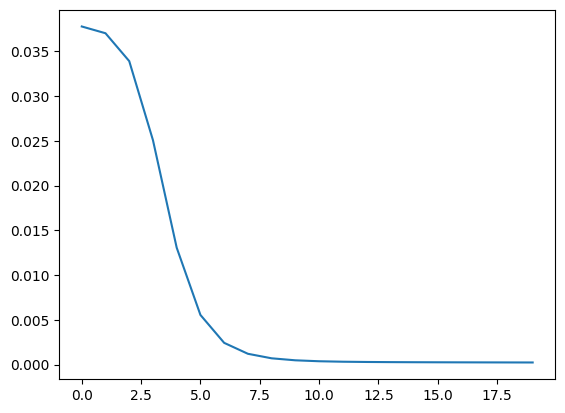

In [5]:
n_hidden_units = 2
W1 = 0.1 * np.random.randn(n_hidden_units, 3)
b1 = np.zeros(n_hidden_units)

n_output_hidden = 1
W2 = 0.1 * np.random.randn(n_output_hidden, 2)
b2 = np.zeros(n_output_hidden)
# print(
#     f"W1.shape {W1.shape}, b1.shape {b1.shape}, W2.shape {W2.shape}, b2.shape {b2.shape}"
# )

losses = []
lr = 0.5
epochs = 20
for epoch in range(epochs):
    train_loss = 0.0
    for x, target in zip(inputs, targets):
        prediction, loss, dW1, db1, dW2, db2 = forward_backward_pass(
            x, target, W1, b1, W2, b2
        )
        train_loss += loss
        # print(f"w1 {W1.shape}, dw1 {dW1.shape}, w2 {W2.shape}, dw2 {dW2.shape}")
        W1 = W1 - lr * dW1
        W2 = W2 - lr * dW2
        b1 = b1 - lr * db1
        b2 = b2 - lr * db2

    losses.append(train_loss / len(targets))
    # print(f"train loss {train_loss:.2} in epoch {epoch}, ")

# plot the loss over time (as measured in epochs)
plt.plot(losses)